In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import ta
import numpy as np
from binance.client import Client

In [92]:
data=Client().get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1HOUR, '01 January 2021')
df=pd.DataFrame(data,columns=["timestamp","open","high", "low", "close", "volume", "close_time", "quote_av", "trades", "tb_base_av", "tb_quote_av", "ignore"])

df = df.set_index(df['timestamp'])
df.index=pd.to_datetime(df.index, unit='ms')

del df['close_time']
del df['quote_av']
del df['trades']
del df['tb_base_av']
del df['tb_quote_av']
del df['ignore']

df

,timestamp,open,high,low,close,volume
timestamp,,,,,,
2021-01-01 00:00:00,1609459200000,28923.63000000,29031.34000000,28690.17000000,28995.13000000,2311.81144500
2021-01-01 01:00:00,1609462800000,28995.13000000,29470.00000000,28960.35000000,29409.99000000,5403.06847100
2021-01-01 02:00:00,1609466400000,29410.00000000,29465.26000000,29120.03000000,29194.65000000,2384.23156000
2021-01-01 03:00:00,1609470000000,29195.25000000,29367.00000000,29150.02000000,29278.40000000,1461.34507700
2021-01-01 04:00:00,1609473600000,29278.41000000,29395.00000000,29029.40000000,29220.31000000,2038.04680300
...,...,...,...,...,...,...
2022-03-27 13:00:00,1648386000000,44436.09000000,44647.24000000,44421.46000000,44616.24000000,988.68354000
2022-03-27 14:00:00,1648389600000,44616.23000000,44741.00000000,44583.52000000,44614.35000000,1121.70585000
2022-03-27 15:00:00,1648393200000,44614.36000000,44933.45000000,44523.23000000,44857.52000000,1990.03084000


In [93]:
df["open"] = df["open"].astype(float)
df["high"] = df["high"].astype(float)
df["low"] = df["low"].astype(float)
df["close"] = df["close"].astype(float)
df["volume"] = df["volume"].astype(float)

In [94]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

dataframe=pd.read_csv(r'C:\Users\lilia\OneDrive\Documents\Lilian\ING4_S2\IA\Projet3\regression.csv')

def learn_regression(data):
    x = data[["lpb","x"]]
    y = data["wallet"]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 100)

    #Fitting the Multiple Linear Regression model
    mlr = LinearRegression()  
    mlr.fit(x_train, y_train)

    y_pred_mlr=mlr.predict(x_test)

    #Actual value and the predicted value
    mlr_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred_mlr})

    #Model Evaluation
    from sklearn import metrics


    return mlr

def prediction(mlr):
    wallet=pd.DataFrame()
    for i in range(10,50):
        for j in range(5,30):
            x=pd.DataFrame([[i,j]],columns=["lpb","x"])
            wallet=wallet.append({'lpb' : int(i),'x' : int(j), 'wallet' :mlr.predict(x) } , ignore_index=True)
    
    wallet["wallet"] = wallet["wallet"].astype(float)
    best_lpb = wallet['lpb'][wallet["wallet"].idxmax()]
    best_x = wallet['x'][wallet["wallet"].idxmax()]

    return best_lpb,best_x

def opti_regression(new_line, data):
    data=pd.concat([data,new_line], ignore_index=True)
    mlr=learn_regression(data)
    best_lpb, best_x=prediction(mlr)
    
    return best_lpb, best_x




In [95]:
def volume_anomality(df, volume_window):
        dfInd = df.copy()
        dfInd["VolAnomaly"] = 0
        dfInd["PreviousClose"] = dfInd["close"].shift(1)
        dfInd['MeanVolume'] = dfInd['volume'].rolling(volume_window).mean()
        dfInd['MaxVolume'] = dfInd['volume'].rolling(volume_window).max()
        dfInd.loc[dfInd['volume'] > 1.5 * dfInd['MeanVolume'], "VolAnomaly"] = 1
        dfInd.loc[dfInd['volume'] > 2 * dfInd['MeanVolume'], "VolAnomaly"] = 2
        dfInd.loc[dfInd['volume'] >= dfInd['MaxVolume'], "VolAnomaly"] = 3
        dfInd.loc[dfInd['PreviousClose'] > dfInd['close'],
                "VolAnomaly"] = (-1) * dfInd["VolAnomaly"]
        return dfInd["VolAnomaly"]

def buyCondition(row, previousRow):
    if (
        row['VOL_ANO'] > 0
        and previousRow['VOL_ANO'] < 0
        and previousRow['close'] <= previousRow['MIN20']
        and previousRow['CANDLE_DIFF'] > row['CANDLE_DIFF']
        and (previousRow['open'] - previousRow['close']) > 0.0025 * row['close']
    ):
        return True
    else:
        return False

# -- Condition to SELL market --
def sellCondition(row, x):
    if (
        row['WillR'] > -x
    ):
        return True
    else:
        return False

In [96]:
def bdd(lbp, x, df) : 

    # -- Indicators, you can edit every value --
    df['VOL_ANO'] = volume_anomality(df, 10)
    df['MIN20'] = df['close'].rolling(10).min()
    df['WillR'] = ta.momentum.williams_r(high=df['high'], low=df['low'], close=df['close'], lbp=lbp)
    df['CANDLE_DIFF'] = abs(df['open'] - df['close'])
    df['MEAN_DIFF'] = df['CANDLE_DIFF'].rolling(20).mean()

    dfTest=df[:]
    previousRow = dfTest.iloc[0]

    # -- Value initialisation --
    startingBalance = 1000
    usd = startingBalance
    wallet = startingBalance
    coin = 0
    
    # -- Iteration on all your price dataset (df) --
    for index, row in dfTest.iterrows():
        # -- Buy market order --
        if buyCondition(row, previousRow) and usd > 0 :
            # -- You can define here at what price you buy --
            buyPrice = row['close']
            coin = usd / buyPrice
            usd = 0
            wallet = coin * row['close']

        # -- Sell Market Order --
        elif sellCondition(row, x):
            if coin > 0:
                # -- You can define here at what price you buy --
                sellPrice = row['close']
                usd = coin * sellPrice
                coin = 0
                wallet = usd
            
        previousRow = row
    return wallet

In [97]:
def BackTesting(df):

    dataframe=pd.read_csv(r'C:\Users\lilia\OneDrive\Documents\Lilian\ING4_S2\IA\Projet3\regression.csv')
    
    # -- Value initialisation --
    startingBalance = 1000
    #makerFee = 0.0002
    #takerFee = 0.0007
    takerFee = 0
    usd = startingBalance
    wallet = startingBalance
    coin = 0

    lbp =40
    x =12
    rolling_min = 20 
    rolling_mean =10

    # -- Indicators, you can edit every value --
    df['VOL_ANO'] = volume_anomality(df, 10)
    df['MIN20'] = df['close'].rolling(rolling_min).min()
    df['WillR'] = ta.momentum.williams_r(high=df['high'], low=df['low'], close=df['close'], lbp=lbp)
    df['CANDLE_DIFF'] = abs(df['open'] - df['close'])
    df['MEAN_DIFF'] = df['CANDLE_DIFF'].rolling(rolling_mean).mean()

    dfTest=df[:]
    previousRow = dfTest.iloc[0]

    Buy=pd.DataFrame(columns=['timestamp','close'])
    Sell=pd.DataFrame(columns=['timestamp','close'])

    # -- Definition of dfTrades, that will be the dataset to do your trades analyses --
    dfTrades = pd.DataFrame(columns=['date', 'position', 'reason','price', 'frais', 'fiat', 'coins', 'wallet', 'timeSince'])

    # -- Iteration on all your price dataset (df) --
    for index, row in dfTest.iterrows():
        # -- Buy market order --
        if buyCondition(row, previousRow) and usd > 0 :
            # -- You can define here at what price you buy --
            buyPrice = row['close']
            fee = takerFee * usd
            usd = usd - fee
            coin = usd / buyPrice
            usd = 0
            wallet = coin * row['close']

            print("Buy COIN at", buyPrice, '$ the', index)
            Buy=Buy.append({'timestamp' : row['timestamp'] , 'close' : row['close']} , ignore_index=True)

            # -- Add the trade to dfTrades to analyse it later --
            myrow = {
                'date': index,
                'position': "Buy",
                'reason': 'Buy Market Order',
                'price': buyPrice,
                'frais': fee,
                'fiat': usd,
                'coins': coin,
                'wallet': wallet
            }
            dfTrades = dfTrades.append(myrow, ignore_index=True)

        # -- Sell Market Order --
        elif sellCondition(row, x):
            if coin > 0:
                # -- You can define here at what price you buy --
                sellPrice = row['close']
                usd = coin * sellPrice
                fee = takerFee * usd
                usd = usd - fee
                coin = 0
                wallet = usd

                Sell=Sell.append({'timestamp' : row['timestamp'] , 'close' : row['close']} , ignore_index=True)

                print("Sell COIN at", sellPrice, '$ the', index)

                # -- Add the trade to DfTrades to analyse it later --
                myrow = {
                    'date': index,
                    'position': "Sell",
                    'reason': 'Sell Market Order',
                    'price': sellPrice,
                    'frais': fee,
                    'fiat': usd,
                    'coins': coin,
                    'wallet': wallet
                }
                dfTrades = dfTrades.append(myrow, ignore_index=True)

                new_line=pd.DataFrame([[lbp,x,wallet]],columns=["lpb", "x", "wallet"])
                lbp, x=opti_regression(new_line, dataframe)
                df['WillR'] = ta.momentum.williams_r(high=df['high'], low=df['low'], close=df['close'], lbp=int(lbp))
        previousRow = row

    return wallet,dfTrades,Buy,Sell



In [98]:
wallet,dfTrades,Buy,Sell=BackTesting(df)
wallet

Buy COIN at 39538.57 $ the 2021-01-10 12:00:00
Sell COIN at 36222.07 $ the 2021-01-13 20:00:00
Buy COIN at 36151.09 $ the 2021-01-15 16:00:00
Sell COIN at 33568.18 $ the 2021-01-25 03:00:00
Buy COIN at 30759.03 $ the 2021-01-27 12:00:00
Sell COIN at 32425.71 $ the 2021-01-28 16:00:00
Buy COIN at 38185.72 $ the 2021-02-07 16:00:00
Sell COIN at 42984.07 $ the 2021-02-08 12:00:00
Buy COIN at 54847.72 $ the 2021-02-22 10:00:00
Sell COIN at 51487.06 $ the 2021-02-25 12:00:00
Buy COIN at 59404.48 $ the 2021-03-15 00:00:00
Sell COIN at 57575.51 $ the 2021-03-17 18:00:00
Buy COIN at 51653.76 $ the 2021-03-25 13:00:00
Sell COIN at 54574.41 $ the 2021-03-26 21:00:00
Buy COIN at 55208.69 $ the 2021-03-28 19:00:00
Sell COIN at 57126.15 $ the 2021-03-29 08:00:00
Buy COIN at 58455.36 $ the 2021-04-03 18:00:00
Sell COIN at 59170.68 $ the 2021-04-05 14:00:00
Buy COIN at 61799.59 $ the 2021-04-16 05:00:00
Sell COIN at 50900.0 $ the 2021-04-26 00:00:00
Buy COIN at 56905.68 $ the 2021-05-02 04:00:00
Sell

2137.798087924526

In [100]:
Buy["timestamp"]=pd.to_datetime(Buy["timestamp"], unit='ms')
Sell["timestamp"]=pd.to_datetime(Sell["timestamp"], unit='ms')

In [74]:
wallet=pd.DataFrame()

for i in range(5,50):
    for j in range(5,30):
                wallet=wallet.append({'lpb' : int(i),'x' : int(j), 'wallet' :bdd(i,j,df) } , ignore_index=True)

wallet.to_csv (r'C:\Users\lilia\OneDrive\Documents\Lilian\ING4_S2\IA\Projet3\regression.csv', index = False, header=True)


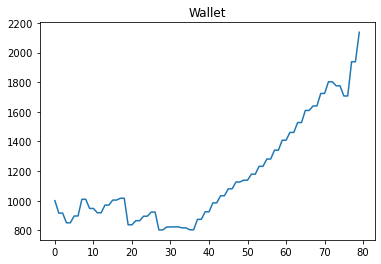

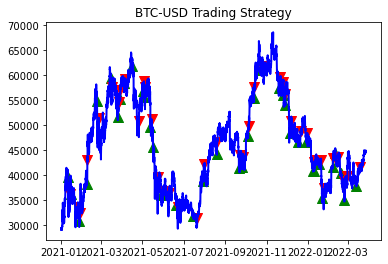

In [101]:
plt.figure()
plt.title('Wallet')
plt.plot(dfTrades["wallet"])
plt.figure()
plt.title('BTC-USD Trading Strategy')
plt.plot(df["close"], color='b', lw=2.)
plt.scatter(Buy["timestamp"],Buy['close'],marker = '^', color='g', s=100 )
plt.scatter(Sell["timestamp"],Sell['close'],marker = 'v', color='r', s=100)